## Problem Statement
US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

At the end to  model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features.

In [966]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import matplotlib.pyplot as plt 
import seaborn as sns


# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [967]:
day = pd.read_csv('day.csv')
day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Data Undestanding and EDA

In [968]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [969]:
day.shape

(730, 16)

##### Observations
- No missing values and null columns
- 730 rows and 16 features


In [970]:
day.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [971]:

#since instant is an id field and does not have significance let's drop it
#Also dteday is not required as already we have year, month and weekday
day.drop(['instant', 'dteday'], axis=1, inplace=True)


#### 
- Mapping the categorical variables to meaningful name


In [1021]:
print(day['holiday'].value_counts())
print(day['workingday'].value_counts())


0    709
1     21
Name: holiday, dtype: int64
1    499
0    231
Name: workingday, dtype: int64


In [973]:
print(day['season'].value_counts())
day['season'] = day['season'].map({1:"spring",2:"summer",3:"fall",4:"winter"})

3    188
2    184
1    180
4    178
Name: season, dtype: int64


In [974]:
print(day['yr'].value_counts())
day['yr'] = day['yr'].map({0:"2018",1:"2019"})


0    365
1    365
Name: yr, dtype: int64


In [975]:
print(day['weekday'].value_counts())
day['weekday'] = day['weekday'].map({0:"Sun",1:"Mon",2:"Tue",3:"Wed",4:"Thur",5:"Fri",6:"Sat"})

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64


In [976]:
print(day['mnth'].value_counts())
day['mnth'] = day['mnth'].map({1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep",10:"Oct",11:"Nov",12:"Dec"})

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64


In [977]:
print(day['weathersit'].value_counts())
day['weathersit'] = day['weathersit'].map({1:"Clear",2:"Mist",3:"Light",4:"Heavy"})

1    463
2    246
3     21
Name: weathersit, dtype: int64


In [978]:
categorical_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

In [979]:
day[categorical_vars] = day[categorical_vars].astype("category")

## Data Visualization

In [980]:
day.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,spring,2018,Jan,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,spring,2018,Jan,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,spring,2018,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,spring,2018,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,spring,2018,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


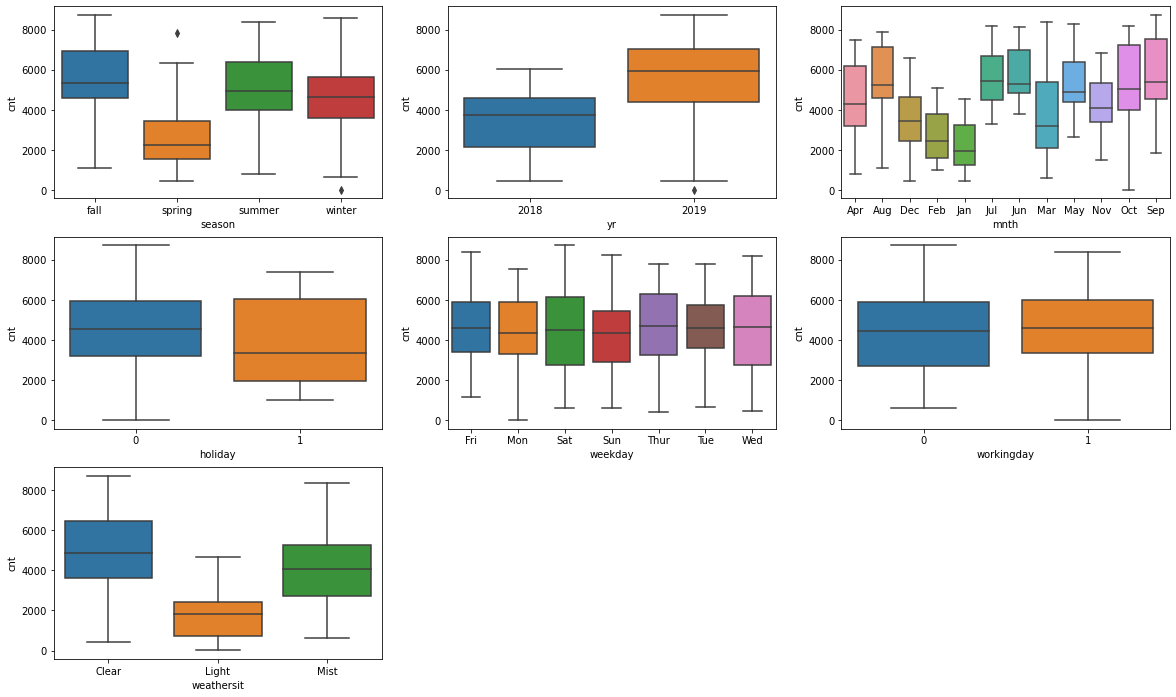

In [981]:
# Analyze Categorical variables
plt.figure(figsize=(20, 12))
plt.subplot(3,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = day)
plt.subplot(3,3,2)
sns.boxplot(x = 'yr', y = 'cnt', data = day)
plt.subplot(3,3,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = day)
plt.subplot(3,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = day)
plt.subplot(3,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = day)
plt.subplot(3,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = day)
plt.subplot(3,3,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = day)
plt.show()


## Observations

- Season - Spring season has lowest biking sharing as compared to other season
- Year - Bike sharing increases by year(2019 > 2018)
- Month - There is a decline in bike sharing count from OCt to march due winter and spring season
- Weekday - It does not have a particular trend
- Weather - Clear, Few clouds, Partly cloudy, Partly cloudy has higher number of bike sharing as compared to other weather 
- 


#### Analyze numeric variables

In [982]:
numeric_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']


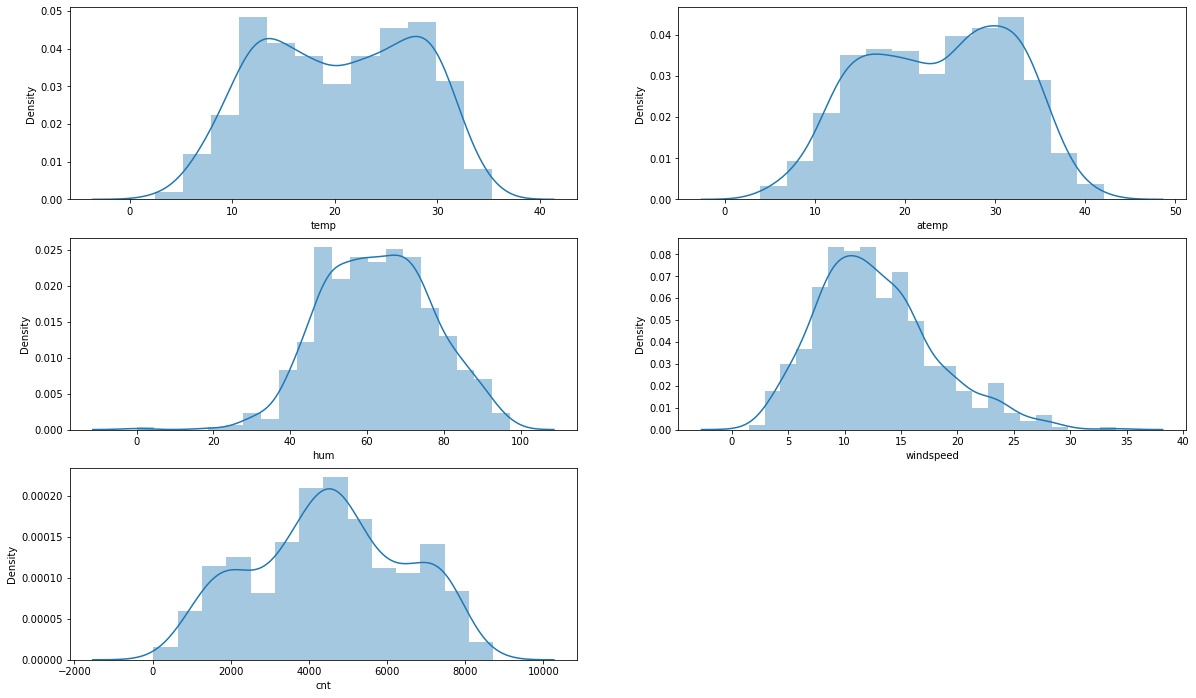

In [983]:
#Analyze numeric variables
plt.figure(figsize=(20, 12))
plt.subplot(3,2,1)
sns.distplot(day['temp'])
plt.subplot(3,2,2)
sns.distplot(day['atemp'])
plt.subplot(3,2,3)
sns.distplot(day['hum'])
plt.subplot(3,2,4)
sns.distplot(day['windspeed'])
plt.subplot(3,2,5)
sns.distplot(day['cnt'])
plt.show()



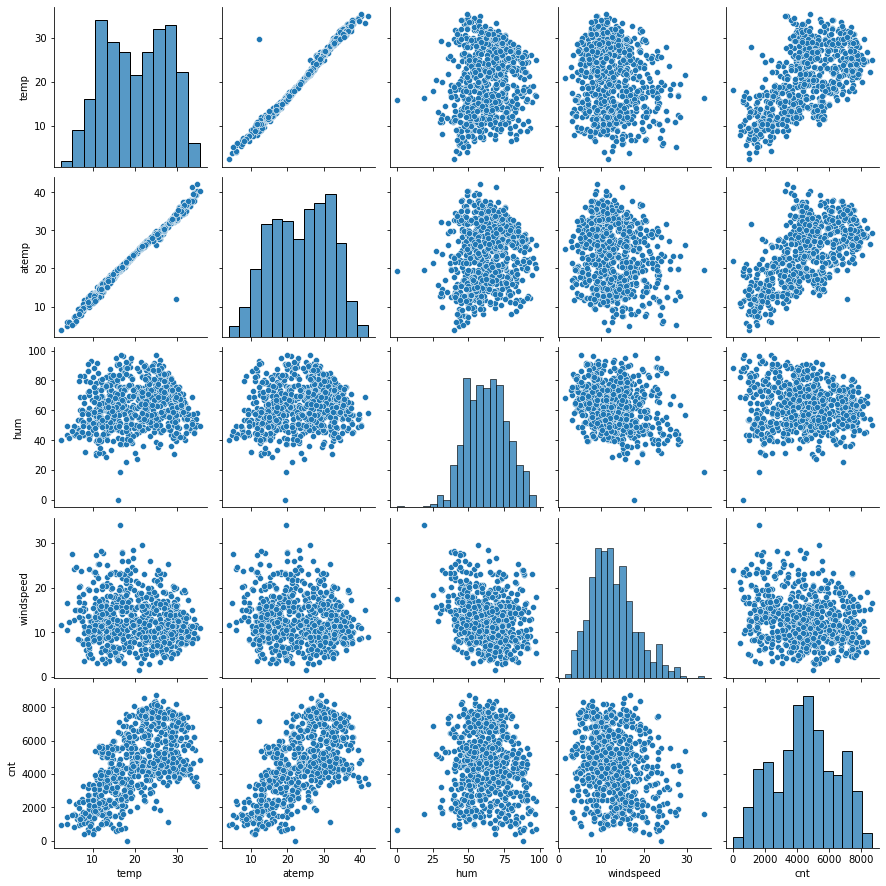

In [984]:
#Analyze numeric variables
sns.pairplot(day, vars=numeric_vars)

plt.show()

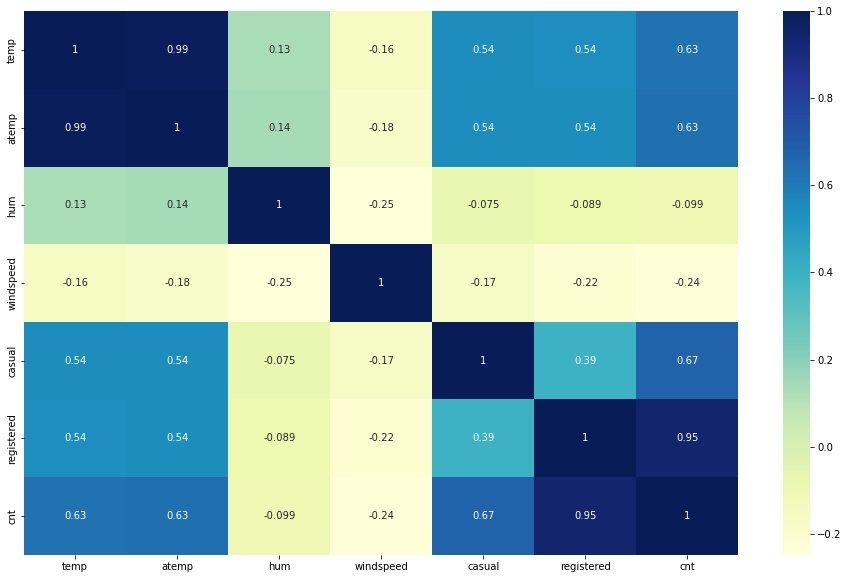

In [985]:
plt.figure(figsize = (16, 10))
sns.heatmap(day.corr(), annot = True, cmap="YlGnBu")
plt.show()

#### Observations

In [986]:
# As we know cnt is the derived attribute and of casual + registered, let's drop casual and registered
day.drop(['casual', 'registered'], axis=1, inplace=True)
#### As we can see from corr matrix , temp and atemp are highly correllated. Let's drop atemp
day.drop(['atemp'], axis=1, inplace=True)

- humidity and windspeed are negatively correlated with bike sharing count

## Data Preparation


In [987]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    category
 2   mnth        730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   hum         730 non-null    float64 
 9   windspeed   730 non-null    float64 
 10  cnt         730 non-null    int64   
dtypes: category(7), float64(3), int64(1)
memory usage: 29.4 KB


### Encoding

#### Add dummy variables

In [988]:
def add_dummy(cat_vars, df):
    for x in cat_vars:
      dummy = pd.get_dummies(df[x],drop_first=True)
      df = pd.concat([dummy, df], axis=1)
    return df
    

In [989]:
# Get the dummy variables for the categorical features 'season', 'mnth', 'weekday', 'weathersit'
cat_vars = ['season', 'mnth', 'weekday', 'weathersit', 'yr']
day = add_dummy(cat_vars, day)
day = day.drop(cat_vars, axis=1)
day.head(100)

,2019,Light,Mist,Mon,Sat,Sun,Thur,Tue,Wed,Aug,...,Sep,spring,summer,winter,holiday,workingday,temp,hum,windspeed,cnt
0,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,14.110847,80.5833,10.749882,985
1,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,14.902598,69.6087,16.652113,801
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,8.050924,43.7273,16.636703,1349
3,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,8.200000,59.0435,10.739832,1562
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,9.305237,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,16.024153,47.0833,17.625221,2808
96,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,17.937500,60.2917,10.874904,3141
97,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,13.769153,83.6250,15.208464,1471
98,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,14.042500,87.7500,8.916561,2455


#### Train Test Data Split

In [990]:
np.random.seed(0)
day_train, day_test = train_test_split(day, train_size=0.7, random_state=100)
print(day_train.shape)
print(day_test.shape)

(510, 29)
(220, 29)


#### Min Max Scaling

In [991]:
scaler = MinMaxScaler()
num_vars=['temp', 'hum', 'windspeed', 'cnt']
day_train[num_vars] = scaler.fit_transform(day_train[num_vars])

In [992]:
day_train.head()

,2019,Light,Mist,Mon,Sat,Sun,Thur,Tue,Wed,Aug,...,Sep,spring,summer,winter,holiday,workingday,temp,hum,windspeed,cnt
576,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0.815169,0.725633,0.264686,0.827658
426,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0.442393,0.640189,0.255342,0.465255
728,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0.245101,0.498067,0.663106,0.204096
482,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0.395666,0.504508,0.188475,0.482973
111,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0.345824,0.751824,0.380981,0.191095


### Train The Model

<Figure size 2160x720 with 0 Axes>

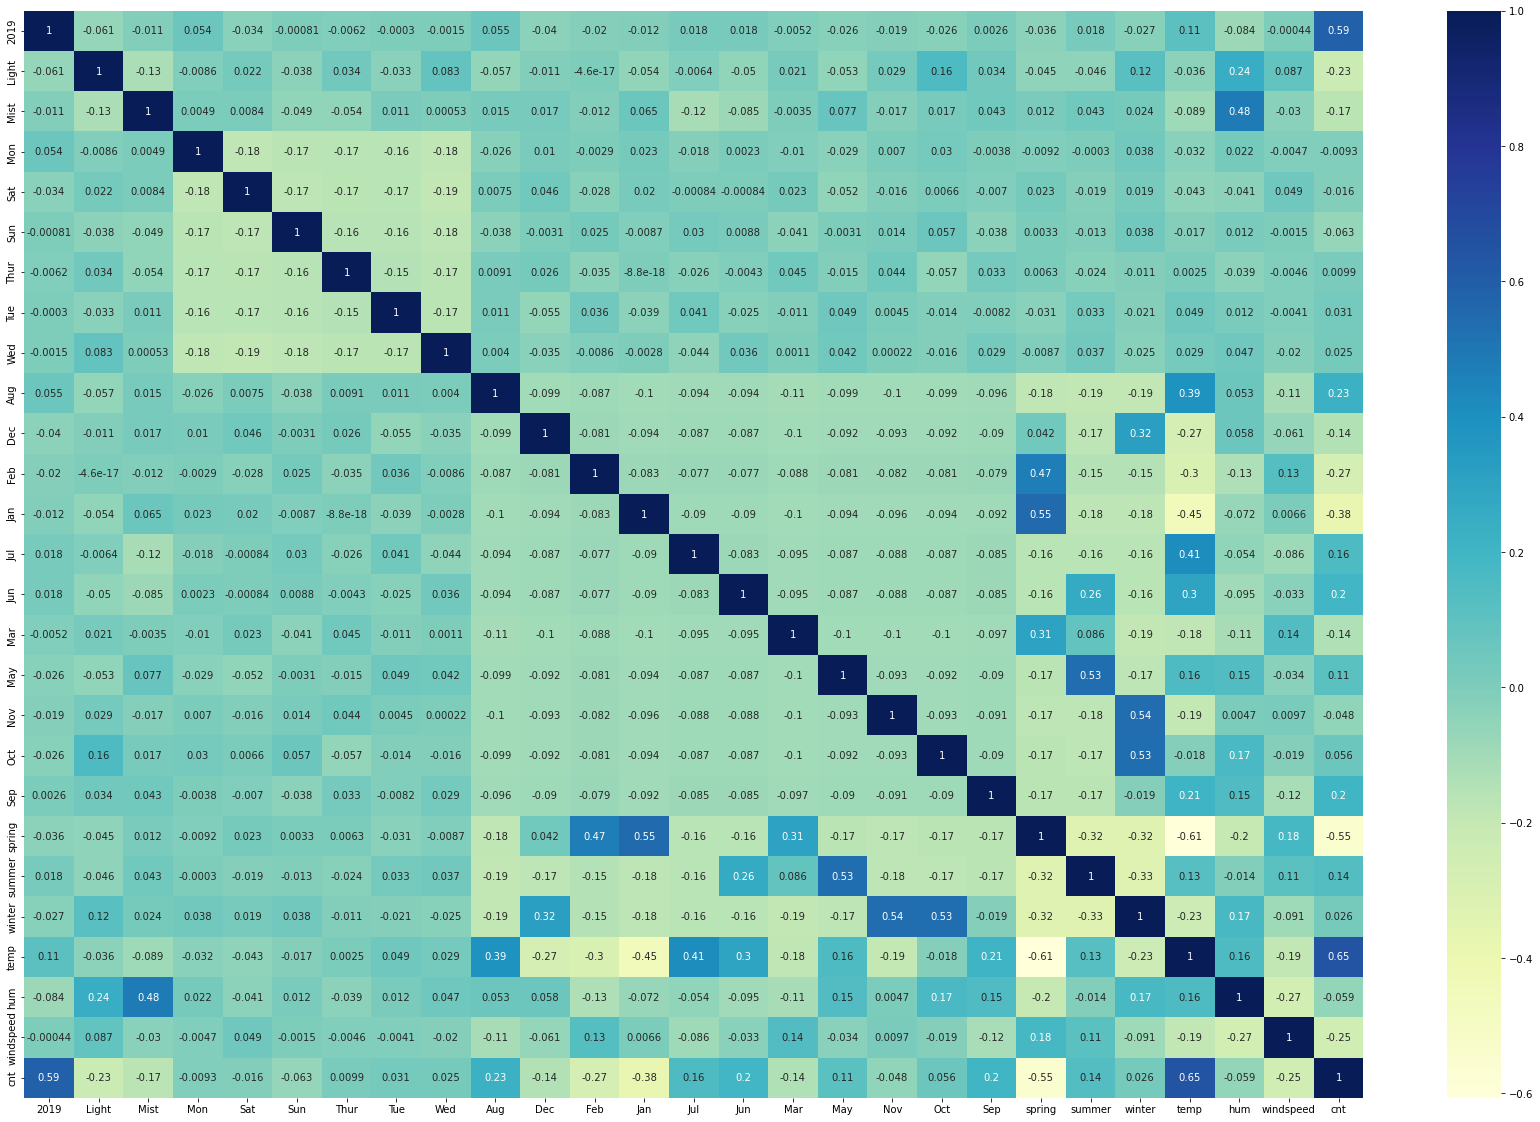

In [993]:
# create correlation matrix with abs values
corr_matrix = day_train.corr()

#since the number attributes are huge let's check highly correllated independent variables
threshold = 0.5
filtered_corr_df = corr_matrix
# filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)] 

plt.figure(figsize=(30,10))

plt.figure(figsize = (30, 20))
sns.heatmap(filtered_corr_df, annot = True, cmap="YlGnBu")

plt.show()

#### Observations


- From the above correlation matrix temp, 2019  is positively highly correlated with biking sharing count

In [994]:
# Create x_train And y_train data set for model building
y_train = day_train.pop('cnt')
x_train = day_train

y_train.head()



576    0.827658
426    0.465255
728    0.204096
482    0.482973
111    0.191095
Name: cnt, dtype: float64

In [995]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 576 to 520
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   2019        510 non-null    uint8   
 1   Light       510 non-null    uint8   
 2   Mist        510 non-null    uint8   
 3   Mon         510 non-null    uint8   
 4   Sat         510 non-null    uint8   
 5   Sun         510 non-null    uint8   
 6   Thur        510 non-null    uint8   
 7   Tue         510 non-null    uint8   
 8   Wed         510 non-null    uint8   
 9   Aug         510 non-null    uint8   
 10  Dec         510 non-null    uint8   
 11  Feb         510 non-null    uint8   
 12  Jan         510 non-null    uint8   
 13  Jul         510 non-null    uint8   
 14  Jun         510 non-null    uint8   
 15  Mar         510 non-null    uint8   
 16  May         510 non-null    uint8   
 17  Nov         510 non-null    uint8   
 18  Oct         510 non-null    uint8   
 19  Sep   

In [996]:
def build_model(cols, x_train, y_train):
    return build_model_for_all_val(x_train[cols], y_train)
   

def build_model_for_all_val(x_train, y_train):
    # add constant
    x_train_sm = sm.add_constant(x_train)

    #create lr
    lr = sm.OLS(y_train, x_train_sm)
    #fit
    sm_model = lr.fit()
    return sm_model


In [997]:
#build model with all the variables

sm_model = build_model_for_all_val(x_train, y_train)
#summary
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     103.2
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          3.00e-181
Time:                        21:40:42   Log-Likelihood:                 527.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     482   BIC:                            -879.5
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2431      0.035      6.888      0.0

#### Observations
- As we can see lots of features with high p-value. Let's apply feature selection to get more significant features

### Feature Selection

In [998]:
def rfe(x_train, y_train, cnt):
    lm = LinearRegression()
    #fit the model
#     lm.fit(x_train, y_train)

    #take top 15 influencing variables
    rfe = RFE(lm, n_features_to_select=cnt) 
    rfe = rfe.fit(x_train, y_train)
    print(list(zip( x_train.columns,rfe.support_, rfe.ranking_)))
    #get all columns that were picked
    col = x_train.columns[rfe.support_]
    col
    # Creating X_test dataframe with RFE selected variables
    x_train_rfe = x_train[col]
    print(x_train_rfe.columns)
    return x_train_rfe


In [999]:
x_train_rfe = rfe(x_train, y_train, 15)

[('2019', True, 1), ('Light', True, 1), ('Mist', True, 1), ('Mon', False, 8), ('Sat', True, 1), ('Sun', True, 1), ('Thur', False, 10), ('Tue', False, 9), ('Wed', False, 11), ('Aug', False, 7), ('Dec', False, 4), ('Feb', False, 5), ('Jan', False, 2), ('Jul', True, 1), ('Jun', False, 13), ('Mar', False, 14), ('May', False, 6), ('Nov', False, 3), ('Oct', False, 12), ('Sep', True, 1), ('spring', True, 1), ('summer', True, 1), ('winter', True, 1), ('holiday', True, 1), ('workingday', True, 1), ('temp', True, 1), ('hum', True, 1), ('windspeed', True, 1)]
Index(['2019', 'Light', 'Mist', 'Sat', 'Sun', 'Jul', 'Sep', 'spring', 'summer',
       'winter', 'holiday', 'workingday', 'temp', 'hum', 'windspeed'],
      dtype='object')


In [1000]:
sm_model = build_model_for_all_val(x_train_rfe, y_train)
#summary
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          2.11e-191
Time:                        21:40:43   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1995      0.028      7.200      0.000       0.145       0.254
2019           0.2298      0.008     28.647      0.000       0.214       0.246
Light         -0.2450      0.026     -9.395      0.000      -0.296      -0.194
Mist          -0.0563      0.010     -5.425      0.000      -0.077      -0.036
Sat            0.0937      0.012      8.040      0.000       0.071       0.117
Sun            0.0406      0.012      3.315      0.001       0.017       0.065
Jul           -0.0546      0.018     -3.019      0.003      -0.090      -0.019
Sep            0.0820      0.017      4.966      0.000       0.050       0.114
spring        -0.0555      0.021     -2.698      0.007      -0.096      -0.015
summer         0.0537      0.015      3.631      0.000       0.025       0.083
winter         0.0992      0.017      5.815      0.000       0.066       0.133
holiday       -0.0184      0.021     -0.867      0.386      -0.060       0.023
workingday     0.0837      0.010      8.665      0.000       0.065       0.103
temp           0.5277      0.033     15.884      0.000       0.462       0.593
hum           -0.1611      0.037     -4.313      0.000      -0.234      -0.088
windspeed     -0.1809      0.025     -7.118      0.000      -0.231      -0.131
==============================================================================
Omnibus:                       64.769   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.630
Skew:                          -0.663   Prob(JB):                     9.73e-35
Kurtosis:                       5.369   Cond. No.                     7.48e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.7e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Observation
- There is no significant decrease in adjusted r2 value after reducing the number of features to 15

#### Let's select less number features i.e 10

In [1001]:
x_train_rfe = rfe(x_train, y_train, 10)

[('2019', True, 1), ('Light', True, 1), ('Mist', False, 4), ('Mon', False, 13), ('Sat', True, 1), ('Sun', True, 1), ('Thur', False, 15), ('Tue', False, 14), ('Wed', False, 16), ('Aug', False, 12), ('Dec', False, 9), ('Feb', False, 10), ('Jan', False, 7), ('Jul', False, 6), ('Jun', False, 18), ('Mar', False, 19), ('May', False, 11), ('Nov', False, 8), ('Oct', False, 17), ('Sep', False, 2), ('spring', False, 5), ('summer', False, 3), ('winter', True, 1), ('holiday', True, 1), ('workingday', True, 1), ('temp', True, 1), ('hum', True, 1), ('windspeed', True, 1)]
Index(['2019', 'Light', 'Sat', 'Sun', 'winter', 'holiday', 'workingday',
       'temp', 'hum', 'windspeed'],
      dtype='object')


In [1002]:
sm_model = build_model_for_all_val(x_train_rfe, y_train)
#summary
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     224.8
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          1.81e-169
Time:                        21:40:43   Log-Likelihood:                 451.67
No. Observations:                 510   AIC:                            -883.3
Df Residuals:                     500   BIC:                            -841.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1821      0.023      7.900      0.000       0.137       0.227
2019           0.2271      0.009     25.122      0.000       0.209       0.245
Light         -0.2040      0.028     -7.341      0.000      -0.259      -0.149
Sat            0.0858      0.012      6.999      0.000       0.062       0.110
Sun            0.0357      0.013      2.808      0.005       0.011       0.061
winter         0.1168      0.011     10.607      0.000       0.095       0.138
holiday       -0.0182      0.023     -0.783      0.434      -0.064       0.027
workingday     0.0788      0.010      8.069      0.000       0.060       0.098
temp           0.6255      0.021     29.366      0.000       0.584       0.667
hum           -0.2370      0.034     -6.971      0.000      -0.304      -0.170
windspeed     -0.1874      0.028     -6.662      0.000      -0.243      -0.132
==============================================================================
Omnibus:                       41.842   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.569
Skew:                          -0.519   Prob(JB):                     2.36e-17
Kurtosis:                       4.589   Cond. No.                     8.39e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.96e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1003]:
# Let's drop holiday since it has high p-value
x_train_rfe.drop('holiday', axis=1, inplace=True)

In [1004]:
sm_model = build_model_for_all_val(x_train_rfe, y_train)
#summary
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     224.8
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          1.81e-169
Time:                        21:40:43   Log-Likelihood:                 451.67
No. Observations:                 510   AIC:                            -883.3
Df Residuals:                     500   BIC:                            -841.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1640      0.039      4.210      0.000       0.087       0.240
2019           0.2271      0.009     25.122      0.000       0.209       0.245
Light         -0.2040      0.028     -7.341      0.000      -0.259      -0.149
Sat            0.1040      0.030      3.438      0.001       0.045       0.163
Sun            0.0539      0.030      1.773      0.077      -0.006       0.114
winter         0.1168      0.011     10.607      0.000       0.095       0.138
workingday     0.0970      0.029      3.390      0.001       0.041       0.153
temp           0.6255      0.021     29.366      0.000       0.584       0.667
hum           -0.2370      0.034     -6.971      0.000      -0.304      -0.170
windspeed     -0.1874      0.028     -6.662      0.000      -0.243      -0.132
==============================================================================
Omnibus:                       41.842   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.569
Skew:                          -0.519   Prob(JB):                     2.36e-17
Kurtosis:                       4.589   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1005]:
x_train_rfe.drop('Sun', axis=1, inplace=True)
sm_model = build_model_for_all_val(x_train_rfe, y_train)
#summary
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     251.4
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          5.27e-170
Time:                        21:40:43   Log-Likelihood:                 450.07
No. Observations:                 510   AIC:                            -882.1
Df Residuals:                     501   BIC:                            -844.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2082      0.030      6.946      0.000       0.149       0.267
2019           0.2273      0.009     25.090      0.000       0.210       0.245
Light         -0.2035      0.028     -7.306      0.000      -0.258      -0.149
Sat            0.0582      0.016      3.689      0.000       0.027       0.089
winter         0.1163      0.011     10.539      0.000       0.095       0.138
workingday     0.0511      0.012      4.180      0.000       0.027       0.075
temp           0.6270      0.021     29.394      0.000       0.585       0.669
hum           -0.2355      0.034     -6.916      0.000      -0.302      -0.169
windspeed     -0.1876      0.028     -6.657      0.000      -0.243      -0.132
==============================================================================
Omnibus:                       43.771   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.264
Skew:                          -0.531   Prob(JB):                     1.37e-18
Kurtosis:                       4.656   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Let's check the multicollinerity using VIF for the selected features

In [1006]:
def cal_vif(x_train):
    vif = pd.DataFrame()
    vif['features']=x_train.columns
    vif['vif'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]
    vif['vif'] = round(vif['vif'], 2)
    vif = vif.sort_values(by='vif', ascending=False)
    return vif

In [1007]:
vif = cal_vif(x_train_rfe)
vif

,features,vif
6,hum,11.45
5,temp,7.01
4,workingday,4.53
7,windspeed,3.60
0,2019,2.02
2,Sat,1.78
3,winter,1.48
1,Light,1.08


In [1008]:
# drop high vif value hum column
x_train_rfe.drop('hum', axis=1, inplace=True)

In [1009]:
sm_model = build_model_for_all_val(x_train_rfe, y_train)
#summary
print(sm_model.summary())

# vif = cal_vif(x_train)
# vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     256.6
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          2.46e-161
Time:                        21:40:43   Log-Likelihood:                 426.82
No. Observations:                 510   AIC:                            -837.6
Df Residuals:                     502   BIC:                            -803.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0537      0.021      2.570      0.0

In [1010]:
vif = cal_vif(x_train_rfe)
vif

,features,vif
5,temp,4.29
4,workingday,3.88
6,windspeed,3.28
0,2019,2.02
2,Sat,1.66
3,winter,1.27
1,Light,1.06


In [1011]:
# x_train.drop('Jun', axis=1, inplace=True)

In [1012]:
sm_model = build_model_for_all_val(x_train_rfe, y_train)
#summary
print(sm_model.summary())
# vif = cal_vif(x_train)
# vif

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     256.6
Date:                Wed, 14 Dec 2022   Prob (F-statistic):          2.46e-161
Time:                        21:40:43   Log-Likelihood:                 426.82
No. Observations:                 510   AIC:                            -837.6
Df Residuals:                     502   BIC:                            -803.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0537      0.021      2.570      0.0

#### Observation
- Now all the selected features has the low p-value i.e less then 0.05 and also the VIF < 5
- And the model looks good with r2 score 78.2 %

## Residual Analysis

In [1013]:
x_train_sm = sm.add_constant(x_train_rfe)
y_train_pred = sm_model.predict(x_train_sm)
res = y_train - y_train_pred

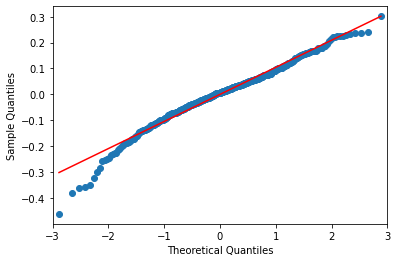

In [1014]:
#look for patterns in residuals
sm.qqplot(res, line ='r')
plt.show()

<AxesSubplot:ylabel='Density'>

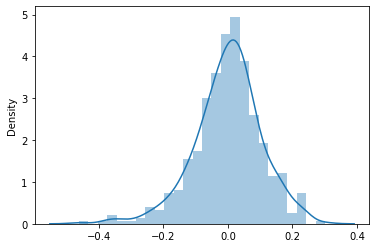

In [1015]:


sns.distplot(res)

### Observations

Errors are normaly distributed and centered around zero

### Prediction And Evaluation On Test Data 

#### Rescaling test data

In [1016]:

num_vars=['temp', 'hum', 'windspeed', 'cnt']

day_test[num_vars] = scaler.transform(day_test[num_vars])
# visualizing the data
day_test.head()

,2019,Light,Mist,Mon,Sat,Sun,Thur,Tue,Wed,Aug,...,Sep,spring,summer,winter,holiday,workingday,temp,hum,windspeed,cnt
184,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0.831783,0.657364,0.084219,0.692706
535,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0.901354,0.610133,0.153728,0.712034
299,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0.511964,0.837699,0.334206,0.303382
221,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,1,0.881625,0.437098,0.339570,0.547400
152,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0.817246,0.314298,0.537414,0.569029


In [1017]:

day_test.describe()

,2019,Light,Mist,Mon,Sat,Sun,Thur,Tue,Wed,Aug,...,Nov,Oct,Sep,spring,summer,winter,temp,hum,windspeed,cnt
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.027273,0.318182,0.127273,0.118182,0.145455,0.163636,0.168182,0.100000,0.059091,...,0.072727,0.086364,0.086364,0.254545,0.263636,0.236364,0.558718,0.638221,0.313293,0.522154
std,0.500809,0.163248,0.466833,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684,0.236333,...,0.260281,0.281541,0.281541,0.436599,0.441609,0.425817,0.233187,0.148694,0.159584,0.219163
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046591,0.261915,-0.042808,0.048205
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.355429,0.529197,0.198843,0.378595
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.558172,0.625590,0.300126,0.524678
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.755981,0.743798,0.402718,0.677750
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984424,1.002146,0.807474,0.963300


In [1018]:
# Let's predict the model using test data
y_test = day_test.pop('cnt')
x_test = day_test

cols = x_train_rfe.columns.to_list()

x_test_predict = x_test[cols]

x_test_sm = sm.add_constant(x_test_predict)
y_test_pred = sm_model.predict(x_test_sm)


#### Check spread y_test vs y_test_pred

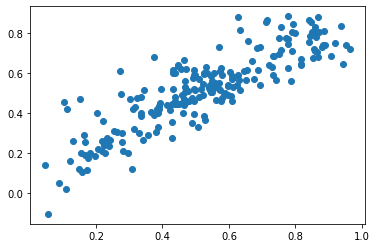

In [1019]:
fig = plt.figure()
plt.scatter(y_test, y_test_pred)

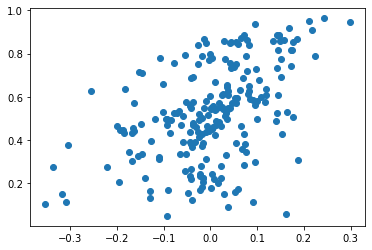

In [1025]:
fig = plt.figure()
plt.scatter(y_test - y_test_pred, y_test)

In [1020]:


r2_score(y_true=y_test, y_pred=y_test_pred)

0.7502520947200688

#### Observation
There is a dip in r2 score by 3% for test data

### Equation

- 0.0537 + 0.2330*yr -0.2541*Light + 0.0616*Sat + 0.1036*winter + 0.0514*workingday +  0.6020*temp - 0.1387windspeed


### Conclusion
Year, Light, Sat, Winter, WorkingDay, temp and winspeed influences bike sharing count